In [1]:
from sklearn.linear_model import LinearRegression

Tstart=1517.921417 
Tend=3760.611359700727

def calc_ttvs_full(p):
    mp1, sqecosw1, sqesinw1, wpn1, P1 = p[3], p[4], p[5], p[6], p[7]
    mp2, sqecosw2, sqesinw2, wpn2, P2 = p[10], p[11], p[12], p[13], p[14]
    e1, e2 = sqecosw1**2 + sqesinw1**2, sqecosw2**2 + sqesinw2**2
    w1, w2 = np.arctan2(sqesinw1, sqecosw1), np.arctan2(sqesinw2, sqecosw2)
    n1, n2 = (wpn1 - w1) % (2 * np.pi), (wpn2 - w2) % (2 * np.pi)

    gravity, stellar_mass = 0.000295994511, 0.73
    planet1 = models.Planet(mp1 / 332946., P1, e1, 90, 180, np.rad2deg(w1), np.rad2deg(n1))
    planet2 = models.Planet(mp2 / 332946., P2, e2, 90, 180, np.rad2deg(w2), np.rad2deg(n2))
    results = ttvfast([planet1, planet2], stellar_mass, Tstart, 0.1, Tend)

    pl, model_epoch, model_tt, model_vsky = map(np.array, [results['positions'][0], results['positions'][1], results['positions'][2], results['positions'][4]])
    pl1_index, pl2_index = np.where((pl == 0) & (model_vsky > 0))[0], np.where((pl == 1) & (model_vsky > 0))[0]
    model_epoch1, model_tt1 = model_epoch[pl1_index], model_tt[pl1_index]
    model_epoch2, model_tt2 = model_epoch[pl2_index], model_tt[pl2_index]

    def linear_regression(X, y):
        regressor = LinearRegression().fit(X.reshape(-1, 1), y)
        residuals = y - regressor.predict(X.reshape(-1, 1))
        return residuals, regressor.coef_

    residuals_tt1, P1 = linear_regression(model_epoch1, model_tt1)
    residuals_tt2, P2 = linear_regression(model_epoch2, model_tt2)
    return model_epoch1, model_epoch2, model_tt1, model_tt2, residuals_tt1, residuals_tt2, P1, P2

In [2]:
## TTVfastで得られたPに対しP_ttvを計算→質量とP_ttv

import rebound
import numpy as np
import matplotlib.pyplot as plt
import h5py
from ttvfast import models, ttvfast
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.nice(19)

with h5py.File('mcmc_pdfit_TESS+GR_2pl_7th.hd5', 'r') as f:
    chain = f['mcmc/chain'][:] if 'mcmc/chain' in f else f['mcmc']['chain'][:]

param_p = 1 / abs(3 / chain[:, :, 14].flatten() - 1 / chain[:, :, 7].flatten())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(chain[:, :, 3].flatten(), param_p, s=0.5, marker='o')
axes[0].set_xlabel('m1')
axes[0].set_ylabel("Pttv")
axes[0].set_title("m1 vs Pttv")

axes[1].scatter(chain[:, :, 10].flatten(), param_p, s=0.5, marker='o')
axes[1].set_xlabel('m2')
axes[1].set_ylabel("Pttv")
axes[1].set_title("m2 vs Pttv")

plt.tight_layout()
plt.show()

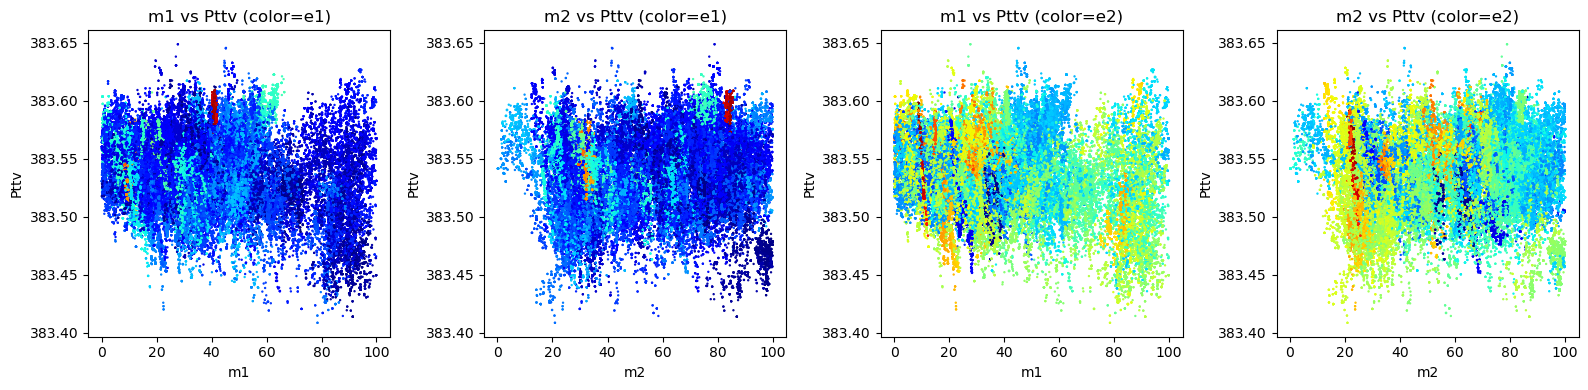

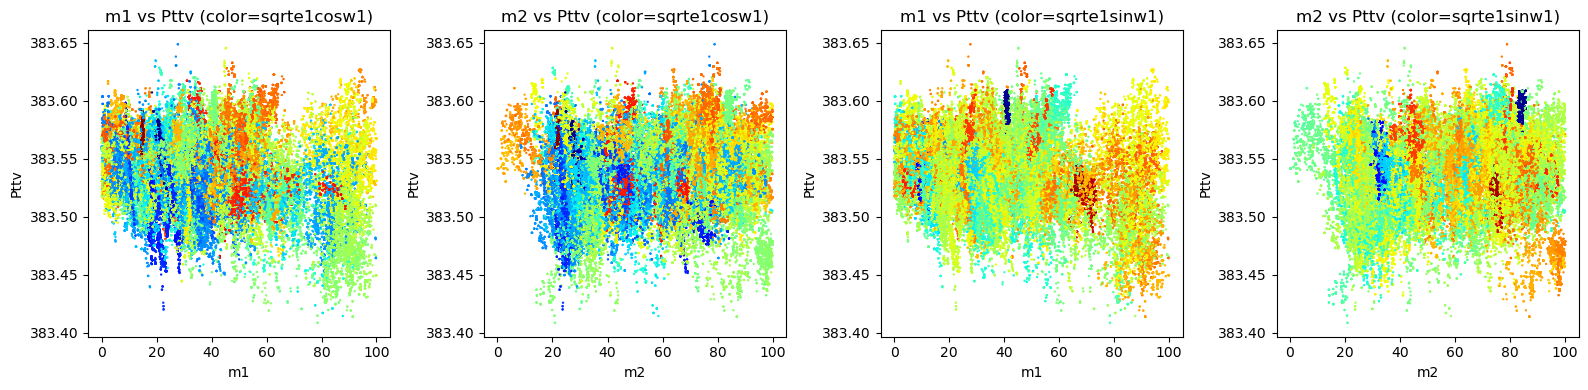

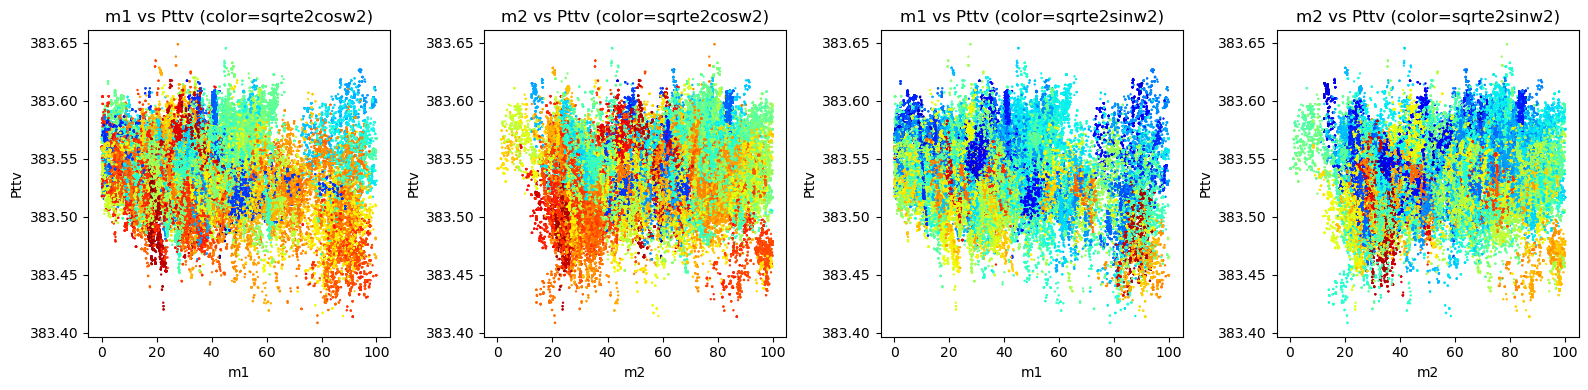

In [76]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

def compute_P_ttv(params):
    results = calc_ttvs_full(params)
    P1 = results[6]
    P2 = results[7]
    return 1 / abs(3 / P2 - 1 / P1)

with h5py.File('mcmc_pdfit_TESS+GR_2pl_7th.hd5', 'r') as f:
    chain = f['mcmc/chain'][:] if 'mcmc/chain' in f else f['mcmc']['chain'][:]
p = chain[::20, :, :].reshape(-1, 29)

m1_list = p[:, 3]
m2_list = p[:, 10]
e1cos=p[:,4]
e1sin=p[:,5]
e2cos=p[:,11]
e2sin=p[:,12]

e1=e1cos**2+e1sin**2
e2=e2cos**2+e2sin**2

norm_1 = mcolors.Normalize(vmin=0, vmax=max0.5)
norm_2 = mcolors.Normalize(vmin=0, vmax=max0.5)
norm_m1 = mcolors.Normalize(vmin=min(m1_list), vmax=max(m1_list))
norm_m2 = mcolors.Normalize(vmin=min(m2_list), vmax=max(m2_list))
color_1 = cm.jet(norm_1(e1))
color_2 = cm.jet(norm_2(e2))
color_m1 = cm.jet(norm_m1(m1_list))
color_m2 = cm.jet(norm_m2(m2_list))

with Pool(processes=cpu_count()) as pool:
    P_ttv = pool.map(compute_P_ttv, p)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(m1_list, P_ttv, s=0.5,c=color_m2)
axes[0].set_xlabel('m1')
axes[0].set_ylabel("Pttv")
axes[0].set_title("m1 vs Pttv (color=m2)")

axes[1].scatter(m2_list, P_ttv, s=0.5,c=color_m1)
axes[1].set_xlabel('m2')
axes[1].set_ylabel("Pttv")
axes[1].set_title("m2 vs Pttv (color=m1)")



plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].scatter(m1_list, P_ttv, s=0.5,c=color_1)
axes[0].set_xlabel('m1')
axes[0].set_ylabel("Pttv")
axes[0].set_title("m1 vs Pttv (color=e1)")

axes[1].scatter(m2_list, P_ttv, s=0.5,c=color_1)
axes[1].set_xlabel('m2')
axes[1].set_ylabel("Pttv")
axes[1].set_title("m2 vs Pttv (color=e1)")

axes[2].scatter(m1_list, P_ttv, s=0.5,c=color_2)
axes[2].set_xlabel('m1')
axes[2].set_ylabel("Pttv")
axes[2].set_title("m1 vs Pttv (color=e2)")

axes[3].scatter(m2_list, P_ttv, s=0.5,c=color_2)
axes[3].set_xlabel('m2')
axes[3].set_ylabel("Pttv")
axes[3].set_title("m2 vs Pttv (color=e2)")

plt.tight_layout()
plt.show()


norm_3 = mcolors.Normalize(vmin=min(p[:,4]), vmax=max(p[:,4]))
norm_4 = mcolors.Normalize(vmin=min(p[:,5]), vmax=max(p[:,5]))
norm_5 = mcolors.Normalize(vmin=min(p[:,11]), vmax=max(p[:,11]))
norm_6 = mcolors.Normalize(vmin=min(p[:,12]), vmax=max(p[:,12]))
color_3 = cm.jet(norm_3(p[:,4]))
color_4 = cm.jet(norm_4(p[:,5]))
color_5 = cm.jet(norm_5(p[:,11]))
color_6 = cm.jet(norm_6(p[:,12]))

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].scatter(m1_list, P_ttv, s=0.5,c=color_3)
axes[0].set_xlabel('m1')
axes[0].set_ylabel("Pttv")
axes[0].set_title("m1 vs Pttv (color=sqrte1cosw1)")

axes[1].scatter(m2_list, P_ttv, s=0.5,c=color_3)
axes[1].set_xlabel('m2')
axes[1].set_ylabel("Pttv")
axes[1].set_title("m2 vs Pttv (color=sqrte1cosw1)")

axes[2].scatter(m1_list, P_ttv, s=0.5,c=color_4)
axes[2].set_xlabel('m1')
axes[2].set_ylabel("Pttv")
axes[2].set_title("m1 vs Pttv (color=sqrte1sinw1)")

axes[3].scatter(m2_list, P_ttv, s=0.5,c=color_4)
axes[3].set_xlabel('m2')
axes[3].set_ylabel("Pttv")
axes[3].set_title("m2 vs Pttv (color=sqrte1sinw1)")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].scatter(m1_list, P_ttv, s=0.5,c=color_5)
axes[0].set_xlabel('m1')
axes[0].set_ylabel("Pttv")
axes[0].set_title("m1 vs Pttv (color=sqrte2cosw2)")

axes[1].scatter(m2_list, P_ttv, s=0.5,c=color_5)
axes[1].set_xlabel('m2')
axes[1].set_ylabel("Pttv")
axes[1].set_title("m2 vs Pttv (color=sqrte2cosw2)")

axes[2].scatter(m1_list, P_ttv, s=0.5,c=color_6)
axes[2].set_xlabel('m1')
axes[2].set_ylabel("Pttv")
axes[2].set_title("m1 vs Pttv (color=sqrte2sinw2)")

axes[3].scatter(m2_list, P_ttv, s=0.5,c=color_6)
axes[3].set_xlabel('m2')
axes[3].set_ylabel("Pttv")
axes[3].set_title("m2 vs Pttv (color=sqrte2sinw2)")

plt.tight_layout()
plt.show()

In [51]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

## ttvfastから得たP_ttvで簡易的なphiとlambda^jを計算
def plot_ttvfast(p):
    results = calc_ttvs_full(p)
    model_epoch1, model_epoch2, model_tt1, model_tt2, residuals_tt1, residuals_tt2, P1, P2 = results
    
    combined_tt = np.sort(np.concatenate((model_tt1, model_tt2)))
    lambda_1 = 2 * np.pi / p[7] * (combined_tt - model_tt1[0])
    lambda_2 = 2 * np.pi / p[14] * (combined_tt - model_tt2[0])
    lambda_j = 3 * lambda_2 - lambda_1

    mask_1 = np.isin(combined_tt, model_tt1)
    mask_2 = np.isin(combined_tt, model_tt2)

    norm = mcolors.Normalize(vmin=1, vmax=100)
    color = cm.jet(norm(p[3]))
    color_2 = cm.jet(norm(p[10]))
    ax[0].plot(lambda_j[mask_1] / (2 * np.pi), residuals_tt1 * 1440, color=color_2, alpha=0.1)
    ax[1].plot(lambda_j[mask_2] / (2 * np.pi), residuals_tt2 * 1440, color=color, alpha=0.1)
    
    ax[0].axhline(y=0, color='r', linestyle='--')
    ax[1].set_xlabel('lambda^j')
    ax[0].set_ylabel('Residuals (TT1)')
    ax[0].set_title('Residuals of TT1 vs Epoch(ttvfast)')

    zero_crossings = np.where(np.diff(np.sign(residuals_tt2)))[0]
    x_values_at_zero = [
        -LinearRegression().fit(
            lambda_j[mask_2][idx-1:idx+2].reshape(-1, 1), residuals_tt2[idx-1:idx+2]
        ).intercept_ / LinearRegression().fit(
            lambda_j[mask_2][idx-1:idx+2].reshape(-1, 1), residuals_tt2[idx-1:idx+2]
        ).coef_[0]
        for idx in zero_crossings if 0 < idx < len(model_tt2) - 1
    ]

    closest_to_025 = min(x_values_at_zero, key=lambda x: abs(x + 1.25*2*np.pi))
    phi = (closest_to_025 + 1.25*2*np.pi)/2/np.pi
    return [p[10], p[3], phi, max(abs(residuals_tt1 * 1440)),max(abs(residuals_tt2 * 1440))]

## 回帰分析から得たP_ttvで簡易的なphiとlambda^jを計算

def plot_liner(p):
    results = calc_ttvs_full(p)
    model_epoch1, model_epoch2, model_tt1, model_tt2, residuals_tt1, residuals_tt2, P1, P2 = results
    
    combined_tt = np.sort(np.concatenate((model_tt1, model_tt2)))
    lambda_1 = 2 * np.pi / P1 * (combined_tt - model_tt1[0])
    lambda_2 = 2 * np.pi / P2 * (combined_tt - model_tt2[0])
    lambda_j = 3 * lambda_2 - lambda_1

    mask_1 = np.isin(combined_tt, model_tt1)
    mask_2 = np.isin(combined_tt, model_tt2)
    
    norm = mcolors.Normalize(vmin=1, vmax=100)
    color = cm.jet(norm(p[3]))
    color_2 = cm.jet(norm(p[10]))
    ax[0].plot(lambda_j[mask_1] / (2 * np.pi), residuals_tt1 * 1440, color=color_2, alpha=0.1)
    ax[1].plot(lambda_j[mask_2] / (2 * np.pi), residuals_tt2 * 1440, color=color, alpha=0.1)
    
    ax[0].axhline(y=0, color='r', linestyle='--')
    ax[1].set_xlabel('lambda^j')
    ax[0].set_ylabel('Residuals (TT1)')
    ax[0].set_title('Residuals of TT1 vs Epoch(liner)')

    zero_crossings = np.where(np.diff(np.sign(residuals_tt2)))[0]
    x_values_at_zero = [
        -LinearRegression().fit(
            lambda_j[mask_2][idx-1:idx+2].reshape(-1, 1), residuals_tt2[idx-1:idx+2]
        ).intercept_ / LinearRegression().fit(
            lambda_j[mask_2][idx-1:idx+2].reshape(-1, 1), residuals_tt2[idx-1:idx+2]
        ).coef_[0]
        for idx in zero_crossings if 0 < idx < len(model_tt2) - 1
    ]
    
    closest_to_025 = min(x_values_at_zero, key=lambda x: abs(x + 1.25*2*np.pi))
    phi = (closest_to_025 + 1.25*2*np.pi)/2/np.pi
    return [p[10], p[3], phi, max(abs(residuals_tt1 * 1440)),max(abs(residuals_tt2 * 1440))]

'''
plot_liner([ 1.51162896e+01 , 5.79202340e-01,  3.79384488e-02,  5.57293771e+01,
 -6.37908186e-02, -3.11231824e-02,  1.80713274e+00,  6.39725422e+00,
  1.29914132e-01 , 3.40887239e-02,  8.87393967e+01 , 1.36089686e-01,
  2.67484165e-02 , 2.58435213e+00,  1.88903925e+01 , 5.17716382e-01,
  1.37431412e-01 ,-1.43639373e+01, -1.40496996e+01 ,-1.54158431e+01,
 -1.40340617e+01 , 5.57218797e-01 , 1.34277494e+00 , 1.85678607e+00,
  1.20008366e+00  ,5.39158751e-04 , 8.87903304e-04 , 5.08726545e-04,
  4.98181664e-04])
'''

'\nplot_liner([ 1.51162896e+01 , 5.79202340e-01,  3.79384488e-02,  5.57293771e+01,\n -6.37908186e-02, -3.11231824e-02,  1.80713274e+00,  6.39725422e+00,\n  1.29914132e-01 , 3.40887239e-02,  8.87393967e+01 , 1.36089686e-01,\n  2.67484165e-02 , 2.58435213e+00,  1.88903925e+01 , 5.17716382e-01,\n  1.37431412e-01 ,-1.43639373e+01, -1.40496996e+01 ,-1.54158431e+01,\n -1.40340617e+01 , 5.57218797e-01 , 1.34277494e+00 , 1.85678607e+00,\n  1.20008366e+00  ,5.39158751e-04 , 8.87903304e-04 , 5.08726545e-04,\n  4.98181664e-04])\n'

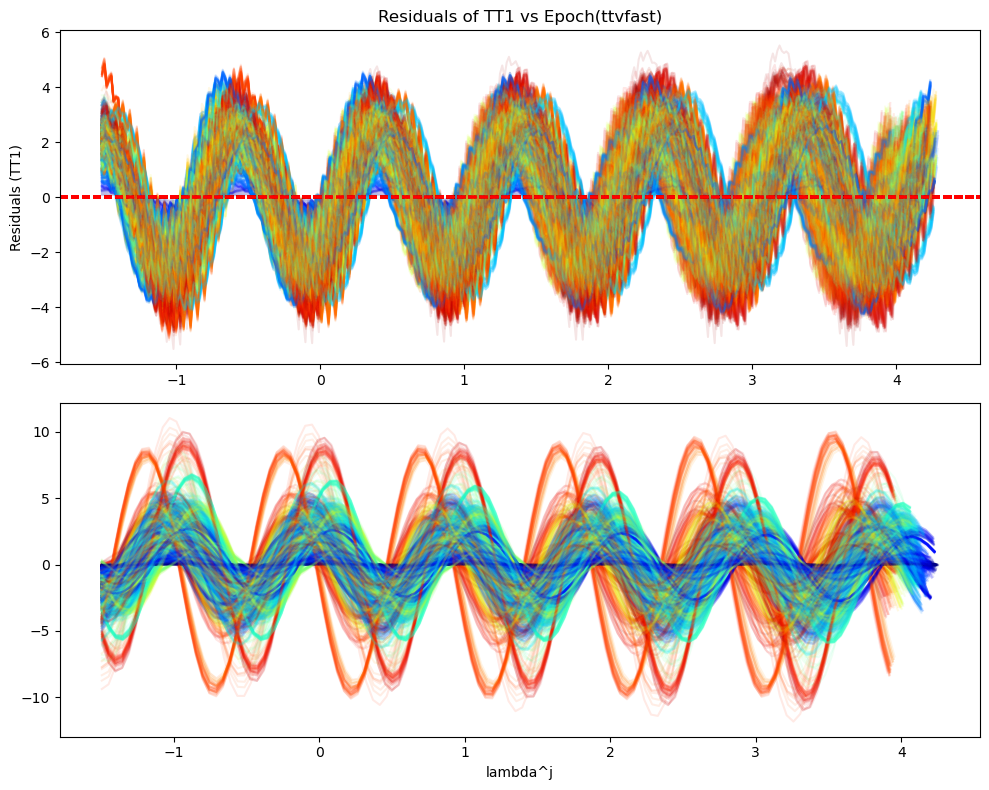

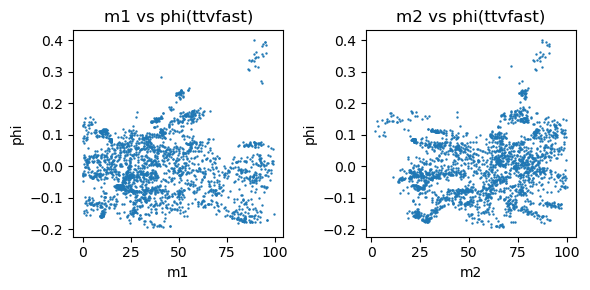

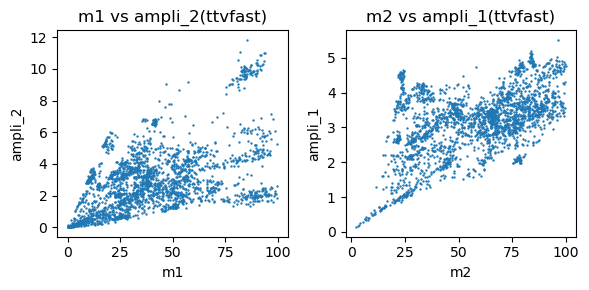

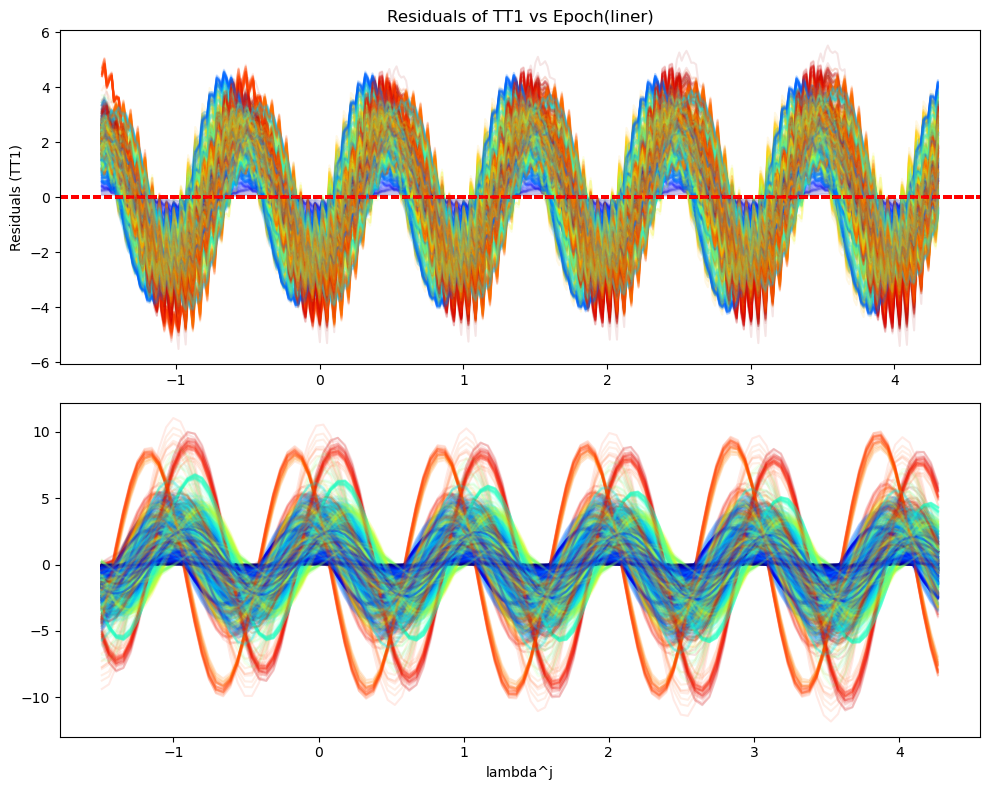

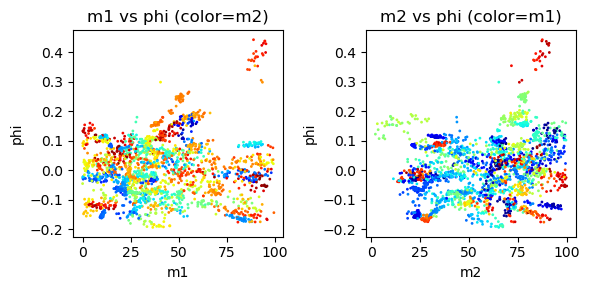

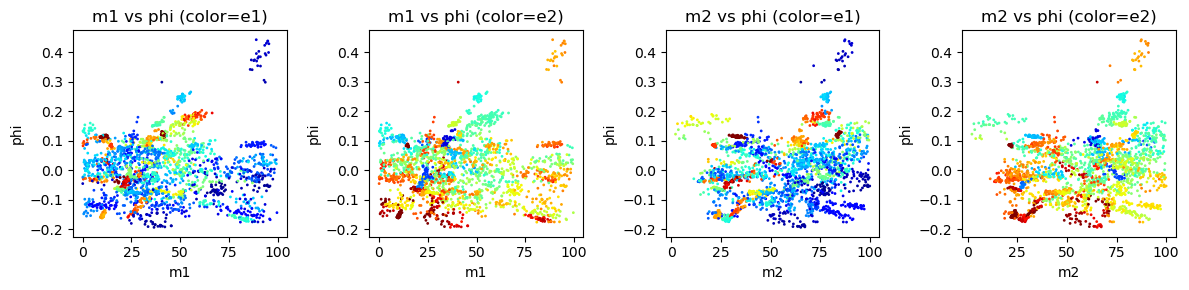

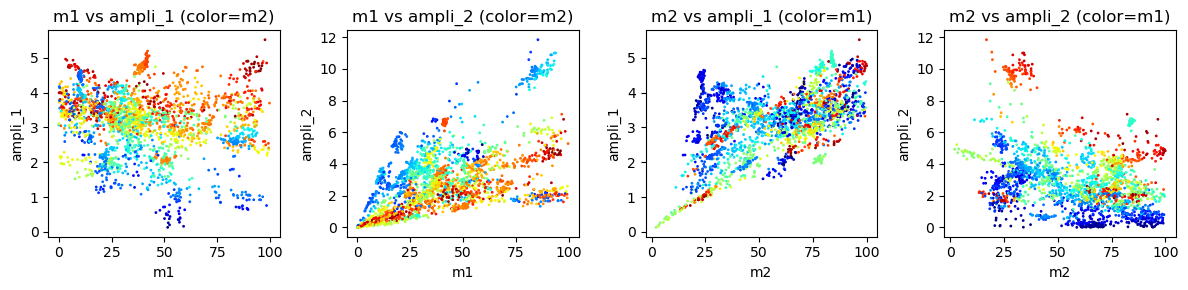

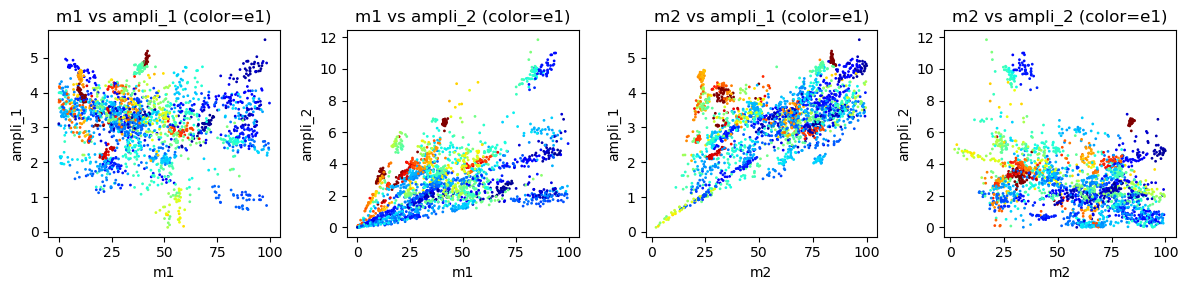

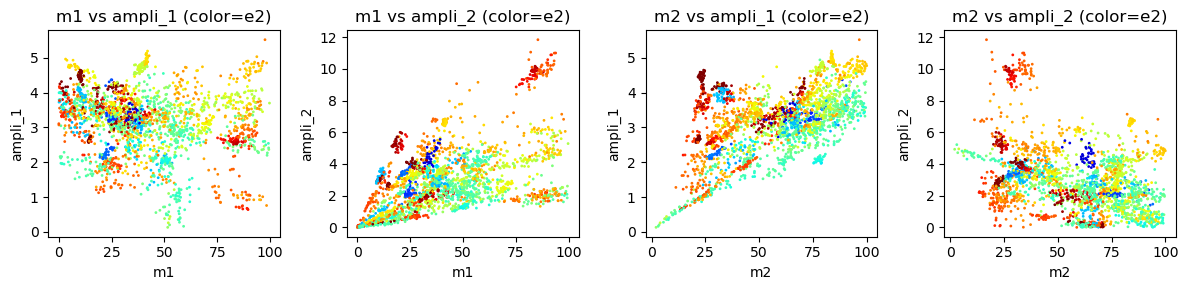

In [81]:
p = chain[::1000, :, :].reshape(-1, 29)
e1cos=p[:,4]
e1sin=p[:,5]
e2cos=p[:,11]
e2sin=p[:,12]

e1=e1cos**2+e1sin**2
e2=e2cos**2+e2sin**2

phi=[]
m1=[]
m2=[]
ampli_1=[]
ampli_2=[]
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
for i in p:
    results = plot_ttvfast(i)
    phi.append(results[2])
    m1.append(results[1])
    m2.append(results[0])
    ampli_1.append(results[3])
    ampli_2.append(results[4])
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].scatter(m1, phi, s=0.5, marker='o')
axes[0].set_xlabel("m1")
axes[0].set_ylabel("phi")
axes[0].set_title("m1 vs phi(ttvfast)")

axes[1].scatter(m2, phi, s=0.5, marker='o')
axes[1].set_xlabel("m2")
axes[1].set_ylabel("phi")
axes[1].set_title("m2 vs phi(ttvfast)")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].scatter(m1, ampli_2, s=0.5, marker='o')
axes[0].set_xlabel("m1")
axes[0].set_ylabel("ampli_2")
axes[0].set_title("m1 vs ampli_2(ttvfast)")

axes[1].scatter(m2, ampli_1, s=0.5, marker='o')
axes[1].set_xlabel("m2")
axes[1].set_ylabel("ampli_1")
axes[1].set_title("m2 vs ampli_1(ttvfast)")
plt.tight_layout()
plt.show()


phi=[]
m1=[]
m2=[]
ampli_1=[]
ampli_2=[]
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
for i in p:
    results = plot_liner(i)
    phi.append(results[2])
    m1.append(results[1])
    m2.append(results[0])
    ampli_1.append(results[3])
    ampli_2.append(results[4])
plt.tight_layout()
plt.show()

norm = mcolors.Normalize(vmin=1, vmax=100)
norm_e=mcolors.Normalize(vmin=0, vmax=0.05)
color = cm.jet(norm(m2))
color_e1 = cm.jet(norm_e(e1))
color_e2 = cm.jet(norm_e(e2))

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].scatter(m1, phi, s=1, marker='o',c=color)
axes[0].set_xlabel("m1")
axes[0].set_ylabel("phi")
axes[0].set_title("m1 vs phi (color=m2)")
norm = mcolors.Normalize(vmin=1, vmax=100)
color = cm.jet(norm(m1))
axes[1].scatter(m2, phi, s=1, marker='o',c=color)
axes[1].set_xlabel("m2")
axes[1].set_ylabel("phi")
axes[1].set_title("m2 vs phi (color=m1)")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].scatter(m1, phi, s=1, marker='o',c=color_e1)
axes[0].set_xlabel("m1")
axes[0].set_ylabel("phi")
axes[0].set_title("m1 vs phi (color=e1)")

axes[1].scatter(m1, phi, s=1, marker='o',c=color_e2)
axes[1].set_xlabel("m1")
axes[1].set_ylabel("phi")
axes[1].set_title("m1 vs phi (color=e2)")

axes[2].scatter(m2, phi, s=1, marker='o',c=color_e1)
axes[2].set_xlabel("m2")
axes[2].set_ylabel("phi")
axes[2].set_title("m2 vs phi (color=e1)")

axes[3].scatter(m2, phi, s=1, marker='o',c=color_e2)
axes[3].set_xlabel("m2")
axes[3].set_ylabel("phi")
axes[3].set_title("m2 vs phi (color=e2)")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(12, 3))
norm_1 = mcolors.Normalize(vmin=1, vmax=100)
color_1 = cm.jet(norm(m1))
norm_2 = mcolors.Normalize(vmin=1, vmax=100)
color_2 = cm.jet(norm(m2))

axes[0].scatter(m1, ampli_1, s=1, marker='o',c=color_2)
axes[0].set_xlabel("m1")
axes[0].set_ylabel("ampli_1")
axes[0].set_title("m1 vs ampli_1 (color=m2)")

axes[1].scatter(m1, ampli_2, s=1, marker='o',c=color_2)
axes[1].set_xlabel("m1")
axes[1].set_ylabel("ampli_2")
axes[1].set_title("m1 vs ampli_2 (color=m2)")

axes[2].scatter(m2, ampli_1, s=1, marker='o',c=color_1)
axes[2].set_xlabel("m2")
axes[2].set_ylabel("ampli_1")
axes[2].set_title("m2 vs ampli_1 (color=m1)")

axes[3].scatter(m2, ampli_2, s=1, marker='o',c=color_1)
axes[3].set_xlabel("m2")
axes[3].set_ylabel("ampli_2")
axes[3].set_title("m2 vs ampli_2 (color=m1)")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
norm_1 = mcolors.Normalize(vmin=1, vmax=100)
color_1 = cm.jet(norm(m1))
norm_2 = mcolors.Normalize(vmin=1, vmax=100)
color_2 = cm.jet(norm(m2))

axes[0].scatter(m1, ampli_1, s=1, marker='o',c=color_e1)
axes[0].set_xlabel("m1")
axes[0].set_ylabel("ampli_1")
axes[0].set_title("m1 vs ampli_1 (color=e1)")

axes[1].scatter(m1, ampli_2, s=1, marker='o',c=color_e1)
axes[1].set_xlabel("m1")
axes[1].set_ylabel("ampli_2")
axes[1].set_title("m1 vs ampli_2 (color=e1)")

axes[2].scatter(m2, ampli_1, s=1, marker='o',c=color_e1)
axes[2].set_xlabel("m2")
axes[2].set_ylabel("ampli_1")
axes[2].set_title("m2 vs ampli_1 (color=e1)")

axes[3].scatter(m2, ampli_2, s=1, marker='o',c=color_e1)
axes[3].set_xlabel("m2")
axes[3].set_ylabel("ampli_2")
axes[3].set_title("m2 vs ampli_2 (color=e1)")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
norm_1 = mcolors.Normalize(vmin=1, vmax=100)
color_1 = cm.jet(norm(m1))
norm_2 = mcolors.Normalize(vmin=1, vmax=100)
color_2 = cm.jet(norm(m2))

axes[0].scatter(m1, ampli_1, s=1, marker='o',c=color_e2)
axes[0].set_xlabel("m1")
axes[0].set_ylabel("ampli_1")
axes[0].set_title("m1 vs ampli_1 (color=e2)")

axes[1].scatter(m1, ampli_2, s=1, marker='o',c=color_e2)
axes[1].set_xlabel("m1")
axes[1].set_ylabel("ampli_2")
axes[1].set_title("m1 vs ampli_2 (color=e2)")

axes[2].scatter(m2, ampli_1, s=1, marker='o',c=color_e2)
axes[2].set_xlabel("m2")
axes[2].set_ylabel("ampli_1")
axes[2].set_title("m2 vs ampli_1 (color=e2)")

axes[3].scatter(m2, ampli_2, s=1, marker='o',c=color_e2)
axes[3].set_xlabel("m2")
axes[3].set_ylabel("ampli_2")
axes[3].set_title("m2 vs ampli_2 (color=e2)")
plt.tight_layout()
plt.show()